## 📥 Data Loading

In [31]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df_car_sales = pd.read_csv('../dataset/vehicles.csv')
df_car_details = pd.read_json('../dataset/vehicle_details.json')

In [32]:
df = df_car_sales.copy()

## 🔍 Feature Selection

In [33]:
drop_columns = ['id', 'url', 'region_url', 'VIN', 'image_url', 'description', 'county', 'lat', 'long']

df.drop(columns = drop_columns, inplace = True)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        426880 non-null  object 
 1   price         426880 non-null  int64  
 2   year          425675 non-null  float64
 3   manufacturer  409234 non-null  object 
 4   model         421603 non-null  object 
 5   condition     252776 non-null  object 
 6   cylinders     249202 non-null  object 
 7   fuel          423867 non-null  object 
 8   odometer      422480 non-null  float64
 9   title_status  418638 non-null  object 
 10  transmission  424324 non-null  object 
 11  drive         296313 non-null  object 
 12  size          120519 non-null  object 
 13  type          334022 non-null  object 
 14  paint_color   296677 non-null  object 
 15  state         426880 non-null  object 
 16  posting_date  426812 non-null  object 
dtypes: float64(2), int64(1), object(14)
memory usage

### 🕒 Datetime Conversion


In [35]:
df["posting_date"] = pd.to_datetime(df["posting_date"], errors="coerce", utc=True)

## 🧼 Data Cleaning Method

### 🧹 Cleaning: Drop Rows with Missing Values

In [36]:
# Drop rows that contain at least one NaN value
print(f"Remaining records before dropping rows with any NaN >> {df.shape[0]}")
df_cleanwdrop = df[df.notna().all(axis=1)]

# Show result
print(f"Remaining records after dropping rows with any NaN >> {df_cleanwdrop.shape[0]}")

Remaining records before dropping rows with any NaN >> 426880
Remaining records after dropping rows with any NaN >> 79195


In [37]:
print(f'Total records (after drop null) of df >> {df_cleanwdrop.shape[0]}')
print(f'Total Duplicated records >> {df_cleanwdrop.duplicated().sum()}')

print(f'Non-Duplicated records >> {df_cleanwdrop.shape[0] - df_cleanwdrop.duplicated().sum()}')

Total records (after drop null) of df >> 79195
Total Duplicated records >> 2
Non-Duplicated records >> 79193


In [38]:
df_cleanwdrop = df_cleanwdrop[~(df_cleanwdrop.duplicated())].copy()

In [39]:
df_cleanwdrop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79193 entries, 31 to 426836
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   region        79193 non-null  object             
 1   price         79193 non-null  int64              
 2   year          79193 non-null  float64            
 3   manufacturer  79193 non-null  object             
 4   model         79193 non-null  object             
 5   condition     79193 non-null  object             
 6   cylinders     79193 non-null  object             
 7   fuel          79193 non-null  object             
 8   odometer      79193 non-null  float64            
 9   title_status  79193 non-null  object             
 10  transmission  79193 non-null  object             
 11  drive         79193 non-null  object             
 12  size          79193 non-null  object             
 13  type          79193 non-null  object             
 14  paint_col

### 🧩 Cleaning: Fill Missing Values
The `sample_df_sales` may have missing data or information that doesn't match the model of the car. We can fill that information using `df_details`.

In [40]:
from fuzzywuzzy import process
from tqdm.auto import tqdm
import re
fuzzy_cache = {}

# Use a dictionary to store previously seen matches

def get_matched_models(df_data, df_details):
    """
    Perform fuzzy matching to match makes and models between sample_df_sales and df_details.

    Parameters:
    sample_df_sales (pd.DataFrame): The sales dataframe containing manufacturer and model information.
    df_details (pd.DataFrame): The details dataframe containing make and model information.

    Returns:
    pd.DataFrame: The updated sample_df_sales dataframe with matched_make and matched_model columns.
    """

    def get_closest_match(row, column, choices):
        if pd.isnull(row[column]):
            return None

        value = str(row[column]).strip().lower()

        # Remove all non-alphanumeric characters for processing
        processed_value = re.sub(r'[^a-z0-9]', '', value)

        # If the processed value is empty, skip matching
        if not processed_value:
            return None

        if value in fuzzy_cache:
            return fuzzy_cache[value]

        match, score = process.extractOne(value, choices)
        result = match if score > 80 else None
        fuzzy_cache[value] = result
        return result

    # Apply fuzzy matching for manufacturer first
    df_details['make'] = df_details['make'].str.lower()
    
    # Add a progress bar to the process
    tqdm.pandas(desc="Matching manufacturers")
    df_data['matched_make'] = df_data.progress_apply(
        lambda row: get_closest_match(row, 'manufacturer', df_details['make'].unique()), axis=1
    )

    # Filter df_details to only include rows with the matched manufacturer
    def filter_models(row):
        if pd.isnull(row['matched_make']):
            return np.array([])  # Return an empty NumPy array
        return df_details[df_details['make'] == row['matched_make']]['model'].unique()

    # Apply fuzzy matching for model based on the filtered models
    def get_closest_model(row):
        models = filter_models(row)
        if models.size == 0:  # Explicitly check if the array is empty
            return None
        return get_closest_match(row, 'model', models)

    # Add a progress bar to the process
    tqdm.pandas(desc="Matching models")
    df_data['matched_model'] = df_data.progress_apply(get_closest_model, axis=1)

    # Calculate the number of matched and unmatched rows
    matched_count = df_data['matched_model'].notnull().sum()
    print(f"Matched: {matched_count} out of {len(df_data)} rows")

    return df_data

In [41]:
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
    
def fill_model_deps(data_df, deps):
        """
        Fill missing values in model-dependent columns using the mode of data grouped by various keys.

        Parameters:
        df (pd.DataFrame): The dataframe to process.
        columns (list): List of model-dependent columns to fill.

        Returns:
        pd.DataFrame: The dataframe with missing values filled.
        """
        # Fill missing values grouped by manufacturer, model, and year
        for col in deps:
            data_df[col] = data_df.groupby(['manufacturer', 'model', 'year'])[col].transform(
                lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x
            )

        # Fill missing values grouped by manufacturer and model
        for col in deps:
            data_df[col] = data_df.groupby(['manufacturer', 'model'])[col].transform(
                lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x
            )

        # Fill missing values grouped by matched_make, matched_model, and year
        for col in deps:
            data_df[col] = data_df.groupby(['matched_make', 'matched_model', 'year'])[col].transform(
                lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x
            )

        # Fill missing values grouped by matched_make and matched_model
        for col in deps:
            data_df[col] = data_df.groupby(['matched_make', 'matched_model'])[col].transform(
                lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x
            )

        return data_df
    
def fill_non_deps(data_df, deps):
    # Define model-dependent columns

    # Select columns to impute (excluding model-dependent columns)
    columns_to_impute = [col for col in data_df.columns if col not in deps]

    # Impute missing values using K-Means clustering

    # Select numeric columns for clustering
    numeric_cols = data_df.select_dtypes(include=[np.number]).columns
    data_for_clustering = data_df[numeric_cols]

    # Impute missing values with the mean before clustering
    imputer = SimpleImputer(strategy='mean')
    data_imputed = imputer.fit_transform(data_for_clustering)

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=data_df['type'].nunique(), random_state=42)
    clusters = kmeans.fit_predict(data_imputed)

    # Add cluster labels to the dataframe
    data_df['cluster'] = clusters

    # Impute missing values in the original dataframe using cluster means
    for col in columns_to_impute:
        if data_df[col].dtype in [np.float64, np.int64]:  # Numeric columns
            data_df[col] = data_df.groupby('cluster')[col].transform(
                lambda x: x.fillna(x.mean())
            )
        elif data_df[col].dtype == object:  # Categorical columns
            data_df[col] = data_df.groupby('cluster')[col].transform(
                lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x
            )
            
    # Drop the cluster column
    data_df.drop(columns=['cluster'], inplace=True)
    
    return data_df


In [42]:
def fill_details(df_data, df_details):
    """
    Fill missing values in target columns of df_data using corresponding source columns from df_details,
    and analyze categorical columns in the updated dataframe.

    Parameters:
    df_data (pd.DataFrame): The sales dataframe.
    df_details (pd.DataFrame): The details dataframe.
    columns_to_fill (dict): A dictionary where keys are target columns in df_data and values are source columns in df_details.

    Returns:
    pd.DataFrame: The updated dataframe with filled values.
    """
    columns_to_fill = {
        'cylinders': 'cylinders_y',
        'fuel': 'fueltype1',
        'transmission': 'trany',
        'type': 'vclass'
    }
    
    # Convert matching columns to lowercase for consistent comparison
    df_data['matched_make'] = df_data['matched_make'].str.lower()
    df_data['matched_model'] = df_data['matched_model'].str.lower()
    df_details['make'] = df_details['make'].str.lower()
    df_details['model'] = df_details['model'].str.lower()
    
    # Merge the dataframes on relevant keys
    merged_df = pd.merge(df_data, df_details, how='left', left_on=['matched_make', 'matched_model', 'year'], right_on=['make','model','year'])[columns_to_fill.values()]

    # Fill missing values in target columns using corresponding source columns
    for target_col, source_col in columns_to_fill.items():
        df_data[target_col] = df_data[target_col].fillna(merged_df[source_col])

    return df_data

In [43]:
def group_values(df):
    """
    Clean and preprocess specific columns in the dataframe.

    Parameters:
    df (pd.DataFrame): The dataframe to clean.

    Returns:
    pd.DataFrame: The cleaned dataframe.
    """
    # Clean the 'cylinders' column to keep only numeric values
    df['cylinders'] = df['cylinders'].str.extract(r'(\d+)').astype('Int64')
    df['transmission'] = df['transmission'].str.split(' ').str[0].str.lower()

    # Group the 'fuel' column into broader categories
    fuel_mapping = {
        'gas': 'gasoline',
        'Regular Gasoline': 'gasoline',
        'Premium Gasoline': 'gasoline',
        'Midgrade Gasoline': 'gasoline',
        'diesel': 'diesel',
        'Diesel': 'diesel',
        'electric': 'electricity',
        'Electricity': 'electricity',
        'hybrid': 'hybrid'
    }
    df['fuel'] = df['fuel'].map(fuel_mapping).fillna(df['fuel'])

    # Group the 'type' column into broader categories
    type_mapping = {
        'sedan': 'car',
        'coupe': 'car',
        'convertible': 'car',
        'hatchback': 'car',
        'wagon': 'car',
        'Midsize Cars': 'car',
        'Compact Cars': 'car',
        'Large Cars': 'car',
        'Subcompact Cars': 'car',
        'Minicompact Cars': 'car',
        'Two Seaters': 'car',
        'SUV': 'suv',
        'Sport Utility Vehicle - 4WD': 'suv',
        'Sport Utility Vehicle - 2WD': 'suv',
        'Small Sport Utility Vehicle 4WD': 'suv',
        'Small Sport Utility Vehicle 2WD': 'suv',
        'Standard Sport Utility Vehicle 4WD': 'suv',
        'Standard Sport Utility Vehicle 2WD': 'suv',
        'Special Purpose Vehicles': 'suv',
        'Special Purpose Vehicle 4WD': 'suv',
        'Special Purpose Vehicle 2WD': 'suv',
        'offroad': 'suv',
        'pickup': 'truck',
        'truck': 'truck',
        'Standard Pickup Trucks 4WD': 'truck',
        'Standard Pickup Trucks 2WD': 'truck',
        'Small Pickup Trucks 4WD': 'truck',
        'Small Pickup Trucks 2WD': 'truck',
        'Small Pickup Trucks': 'truck',
        'Standard Pickup Trucks': 'truck',
        'mini-van': 'van',
        'van': 'van',
        'bus': 'van',
        'Minivan - 2WD': 'van',
        'Minivan - 4WD': 'van',
        'Vans': 'van',
        'Vans, Cargo Type': 'van',
        'Vans, Passenger Type': 'van',
        'Small Station Wagons': 'car',
        'Midsize Station Wagons': 'car'
    }
    df['type'] = df['type'].map(type_mapping).fillna(df['type'])

    return df

In [44]:

def clean_data(df_data, df_details):
    """
    Clean the sales and details dataframes by removing rows with missing values
    and resetting the index.

    Parameters:
    df_data (pd.DataFrame): The sales dataframe.
    df_details (pd.DataFrame): The details dataframe.

    Returns:
    pd.DataFrame, pd.DataFrame: The cleaned sales and details dataframes.
    """
    
    # Select relevant columns
    df_data, df_details = df, df_car_details
    # Replace 'other' values with NaN
    df_data.replace('other', np.nan, inplace=True)
    
    # Merge the dataframes to get more details
    df_data = get_matched_models(df_data, df_details)
    df_data = df_data[~df_data['matched_make'].isnull() & ~df_data['matched_model'].isnull()]
    
    # model_dependent_columns = ['cylinders', 'fuel', 'transmission', 'drive', 'size', 'type']
    model_dependent_columns = df_data
    
    # Fill model dependent values using df_details
    df_data = fill_details(df_data, df_details)
    df_data = group_values(df_data)

    # Fill model dependent values using modes of each model
    df_data = fill_model_deps(df_data, model_dependent_columns)
    
    df_data = df_data.dropna()
    
    return df_data

In [45]:
df_cleanwfill = clean_data(df, df_car_details)

Matching manufacturers:   0%|          | 0/426880 [00:00<?, ?it/s]

Matching models:   0%|          | 0/426880 [00:00<?, ?it/s]

Matched: 379521 out of 426880 rows


In [46]:
# Drop rows that contain at least one NaN value
print(f"Remaining records before fill with stat >> {df.shape[0]}")

# Show result
print(f"Remaining records after fill with stat >> {df_cleanwfill.shape[0]}")

Remaining records before fill with stat >> 426880
Remaining records after fill with stat >> 374817


In [47]:
print(f'Total records (after fill stat) of df >> {df_cleanwfill.shape[0]}')
print(f'Total Duplicated records >> {df_cleanwfill.duplicated().sum()}')

print(f'Non-Duplicated records >> {df_cleanwfill.shape[0] - df_cleanwfill.duplicated().sum()}')

Total records (after fill stat) of df >> 374817
Total Duplicated records >> 26
Non-Duplicated records >> 374791


In [48]:
df_cleanwfill = df_cleanwfill[~(df_cleanwfill.duplicated())].copy()

In [49]:
df_cleanwfill.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374791 entries, 27 to 426879
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   region         374791 non-null  object             
 1   price          374791 non-null  float64            
 2   year           374791 non-null  float64            
 3   manufacturer   374791 non-null  object             
 4   model          374791 non-null  object             
 5   condition      374791 non-null  object             
 6   cylinders      374791 non-null  Int64              
 7   fuel           374791 non-null  object             
 8   odometer       374791 non-null  float64            
 9   title_status   374791 non-null  object             
 10  transmission   374791 non-null  object             
 11  drive          374791 non-null  object             
 12  size           374791 non-null  object             
 13  type           374791 non-null  o

In [50]:
df_cleanwfill.to_csv('../dataset/cleanedwfill_sales_data.csv', index=False)
df_cleanwdrop.to_csv('../dataset/cleanedwdrop_sales_data.csv', index=False)

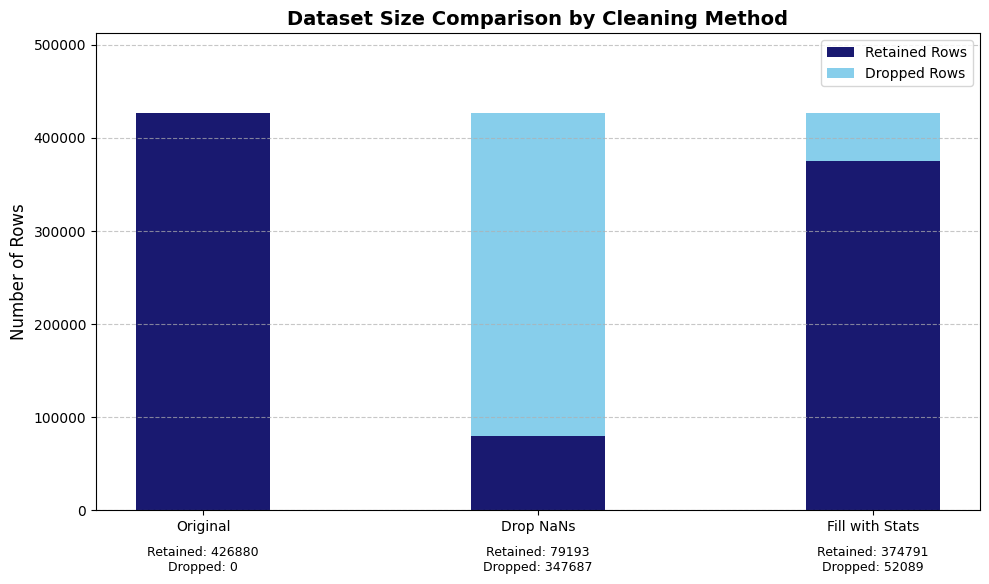

In [51]:
import matplotlib.pyplot as plt

# Total original rows
total_rows = df_car_sales.shape[0]

# Row counts
rows_original = df_car_sales.shape[0]
rows_drop = df_cleanwdrop.shape[0]
rows_fill = df_cleanwfill.shape[0]

# Calculate dropped rows
dropped_drop = total_rows - rows_drop
dropped_fill = total_rows - rows_fill

# Data for plotting
methods = ['Original', 'Drop NaNs', 'Fill with Stats']
retained = [rows_original, rows_drop, rows_fill]
dropped = [0, dropped_drop, dropped_fill]

# Plot
plt.figure(figsize=(10, 6))
bar_width = 0.4
bar_positions = range(len(methods))

bars_retained = plt.bar(bar_positions, retained, label='Retained Rows', color='#191970', width=bar_width)
bars_dropped = plt.bar(bar_positions, dropped, bottom=retained, label='Dropped Rows', color='#87ceeb', width=bar_width)

# Decorations
plt.title('Dataset Size Comparison by Cleaning Method', fontsize=14, fontweight='bold')
plt.ylabel('Number of Rows', fontsize=12)
plt.xticks(bar_positions, methods, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add row counts under each bar
for i, method in enumerate(methods):
    total = retained[i] + dropped[i]
    plt.text(i, -0.09 * total_rows, f'Retained: {retained[i]}\nDropped: {dropped[i]}',
             ha='center', va='top', fontsize=9, color='black')

plt.tight_layout()
plt.ylim(0, total_rows * 1.2)  # Adds 10% space above the tallest bar
plt.show()